In [3]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [71]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%matplotlib inline

import os
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as scipystats

from utils.neurosuite import get_unit_names_sorted
from utils.psth import get_shuffled
#from utils.events import get_sound_event_periods

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Read phase locking data

In [65]:
#source  = '/Users/andrey/sandbox/'
source  = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
#source  = '/mnt/nevermind.data-share/ag-grothe/AG_Pecka/data/processed/'

#session = '013608_ppcSIT_2025-01-06_13-20-52'  # PPC
session = '013608_ppcSIT_2025-01-14_10-20-14'  # HPC
#session = '013608_ppcSIT_2025-01-15_14-56-18'  # HPC
#session = '013608_ppcSIT_2025-01-16_09-49-21'  # PPC
#session = '013608_ppcSIT_2025-01-20_09-38-20'  # HPC
#session = '013608_ppcSIT_2025-01-21_08-50-02'  # Thalamus
#session = '013608_ppcSIT_2025-01-22_12-59-00'  # PPC
#session = '013608_ppcSIT_2025-01-23_08-46-51'  # HPC
#session = "013608_ppcSIT_2025-03-05_10-33-41"  # HPC / Thalamus

animal      = session.split('_')[0]
meta_file   = os.path.join(source, animal, session, 'meta.h5')
units_file  = os.path.join(source, animal, session, 'units.h5')
phsl_file = os.path.join(source, animal, session, 'analysis', 'sound_phase_lock.h5')

In [125]:
# reading events and spiking data
with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    sound_events = np.array(f['processed']['sound_events'])
    cfg = json.loads(f['processed'].attrs['parameters'])
    tgt_mx = np.array(f['processed']['target_matrix'])

spike_times = {}
unit_sic = {}
inst_rates = {}
with h5py.File(units_file, 'r') as f:
    unit_names = get_unit_names_sorted([name for name in f])
    for unit_name in f:
        spike_times[unit_name] = np.array(f[unit_name]['spike_times'])
        inst_rates[unit_name] = np.array(f[unit_name]['inst_rate'])
        unit_sic[unit_name] = float(np.array(f[unit_name]['spatial_information']))

In [67]:
# read phase locking data
with h5py.File(phsl_file, 'r') as f:
    conditions = [x for x in f]
    unit_ids   = [x for x in f[conditions[0]]]
    
MRL_mx = np.zeros([len(unit_ids), 6])  # MRL, p-value
with h5py.File(phsl_file, 'r') as snd_f:
    for i, unit_name in enumerate(unit_ids):
        MRL_tgt     = np.array(snd_f['tgt'][unit_name]['MRL_real'])
        pv_tgt      = np.array(snd_f['tgt'][unit_name]['p_value'])
        MRL_bgr_sta = np.array(snd_f['bgr_sta'][unit_name]['MRL_real'])
        pv_bgr_sta  = np.array(snd_f['bgr_sta'][unit_name]['p_value'])
        MRL_bgr_run = np.array(snd_f['bgr_run'][unit_name]['MRL_real'])
        pv_bgr_run  = np.array(snd_f['bgr_run'][unit_name]['p_value'])
        MRL_mx[i] = np.array([MRL_tgt, pv_tgt, MRL_bgr_sta, pv_bgr_sta, MRL_bgr_run, pv_bgr_run])

In [68]:
x_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 1]
y_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 2]
speed_ev = tl[sound_events[:, 2].astype(np.int32)][:, 3]

idxs_sta_ev = np.where(speed_ev < 0.04)[0]
idxs_run_ev = np.where(speed_ev > 0.04)[0]
idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]
idxs_di1_ev = np.where(sound_events[:, 1] == 3)[0]
idxs_di2_ev = np.where(sound_events[:, 1] == 4)[0]

pulse_times = sound_events[:, 0]

## Compute MRL manually

In [10]:
def get_phases(pulse_times, spk_times, offset=0.25):
    phases = []
    for i, p_time in enumerate(pulse_times):
        selected = spk_times[(spk_times > p_time) & (spk_times < p_time + offset)]
        phases += [2 * np.pi * x/offset for x in selected - p_time]
    
    return np.array(phases)

In [66]:
unit_MRLs = {}
phase_types = ['tgt', 'bgr']
phase_idxs  = [idxs_tgt_ev, idxs_bgr_ev]
n_shuffles = 100
ipi_for_shuffle = 0.25

for k, idxs_to_phase in enumerate(phase_idxs):
    MRLs_by_event_type = {}
    for j, (unit_id, spk_times) in enumerate(spike_times.items()):
        
        # get all spike phases
        phases = get_phases(pulse_times[idxs_to_phase], spk_times)
        
        # no spikes
        if len(phases) == 0:
            MRLs_by_event_type[unit_id] = { 
                "MRL_real": 0,
                "MRLs_shuffled": np.zeros(n_shuffles),
                "p_value": 1.0
            }
            continue
            
        # real MRL
        MRL_real = np.abs(np.mean(np.exp(1j * np.array(phases))))

        # staple spikes / pulses for shuffle controls
        shift = 0
        spikes_adjusted = []
        pulses_adjusted = []
        for i in idxs_to_phase:
            if i >= len(pulse_times):
                continue

            selected = spk_times[(spk_times > pulse_times[i]) & (spk_times < pulse_times[i+1])]
            spikes_adjusted += [x + shift for x in selected - pulse_times[i]]
            pulses_adjusted += [shift]
            shift += ipi_for_shuffle

        # do shuffle controls
        MRLs_shuffled = []
        for _ in range(n_shuffles):
            strain_shuf = get_shuffled(spikes_adjusted)
            phases_shuf = get_phases(pulses_adjusted, strain_shuf)
            MRLs_shuffled.append(np.abs(np.mean(np.exp(1j * np.array(phases_shuf)))))
        MRLs_shuffled = np.array(MRLs_shuffled)

        # fraction of shuffled MRLs greater than real MRL
        p_value = np.mean(MRLs_shuffled >= MRL_real)

        MRLs_by_event_type[unit_id] = { 
            "MRL_real": MRL_real,
            "MRLs_shuffled": MRLs_shuffled,
            "p_value": p_value
        }
        print(f"Unit {unit_id} completed ({j} from {len(spike_times)}); ev type: {phase_types[k]}\r", end='')
        
    unit_MRLs[phase_types[k]] = dict(MRLs_by_event_type)

In [82]:
unit_id = '4-448'
ev_id = 'tgt'
print(unit_MRLs[ev_id][unit_id]['MRL_real'])
print(unit_MRLs[ev_id][unit_id]['MRLs_shuffled'].mean())
print(unit_MRLs[ev_id][unit_id]['p_value'])

0.1370216476094484
0.055484263178657234
0.02


## Phase locking in diff states

In [69]:
conditions = ['bgr', 'tgt', 'bgr_sta', 'bgr_run', 'PH', 'AL']

[Text(1, 0, 'bgr'),
 Text(2, 0, 'tgt'),
 Text(3, 0, 'bgr_sta'),
 Text(4, 0, 'bgr_run'),
 Text(5, 0, 'PH'),
 Text(6, 0, 'AL')]

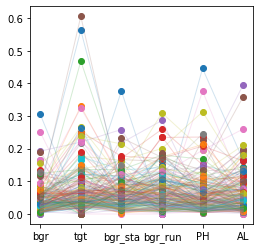

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

x_vals = np.arange(len(conditions)) + 1
with h5py.File(phsl_file, 'r') as f:
    for unit_id in unit_ids:
        MRLs_real = np.array([float(np.array(f[cond][unit_id]['MRL_real'])) for cond in conditions])
        MRLs_shuf = np.array([np.array(f[cond][unit_id]['MRLs_shuffled']).mean() for cond in conditions])
        ax.scatter(x_vals, MRLs_real)
        ax.plot(x_vals, MRLs_real, lw=1, alpha=0.2)
        
#ax.set_yscale('log')
ax.set_xticks(x_vals)
ax.set_xticklabels(conditions)

## MRL / p-values distributions

36 units with phase locking selected
151 units have kind of no phase locking


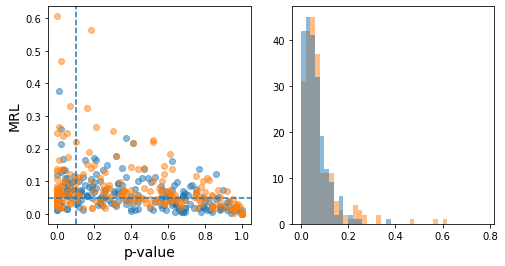

In [76]:
# selection criteria
pv_min = 0.1
MRL_min = 0.05

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.scatter(MRL_mx[:, 3], MRL_mx[:, 2], color='tab:blue', alpha=0.5)
ax.scatter(MRL_mx[:, 1], MRL_mx[:, 0], color='tab:orange', alpha=0.5)

#ax.scatter(MRL_mx[:, 5], MRL_mx[:, 4], color='tab:red', alpha=0.5)
#for i in range(len(MRL_mx)):
#    ax.plot([MRL_mx[i][1], MRL_mx[i][3]], [MRL_mx[i][0], MRL_mx[i][2]], color='grey', alpha=0.5)
ax.axvline(pv_min, ls='--')
ax.axhline(MRL_min, ls='--')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('p-value', fontsize=14)
ax.set_ylabel('MRL', fontsize=14)

bins = np.arange(0, 0.8, 0.02)
ax = axes[1]
ax.hist(MRL_mx[:, 0], bins=bins, color='tab:orange', alpha=0.5)
_ = ax.hist(MRL_mx[:, 2], bins=bins, color='tab:blue', alpha=0.5)

idxs_MRL_high = np.where((MRL_mx[:, 0] > MRL_min) & (MRL_mx[:, 1] < pv_min))[0]
idxs_MRL_low  = np.where(MRL_mx[:, 1] > pv_min)[0]
print(f"{len(idxs_MRL_high)} units with phase locking selected")
print(f"{len(idxs_MRL_low)} units have kind of no phase locking")

## Spatial tuning

In [1]:
# - are they spatially tuned? Kind of less SIC, less tuned, but there is a correlation
# - where they are anatomically? Kind of no preference, in CA1 / CA3 and in between
# - what are their firing rates? pyramids on interns?

In [59]:
sic_MRL_mx = np.zeros([len(unit_ids), 2])
for i, unit_id in enumerate(unit_ids):
    sic_MRL_mx[i] = np.array([unit_sic[unit_id], MRL_mx[i][0]])

SIC difference between high / low MRL, p_value: 0.00205
SIC / MRL correlation: 0.27, p=0.00008


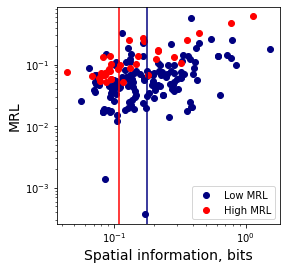

In [87]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
ax.scatter(sic_MRL_mx[idxs_MRL_low][:, 0], sic_MRL_mx[idxs_MRL_low][:, 1], color='navy', label='Low MRL')
ax.scatter(sic_MRL_mx[idxs_MRL_high][:, 0], sic_MRL_mx[idxs_MRL_high][:, 1], color='red', label='High MRL')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Spatial information, bits', fontsize=14)
ax.set_ylabel('MRL', fontsize=14)
ax.axvline(np.median(sic_MRL_mx[:, 0][idxs_MRL_low]), color='navy')
ax.axvline(np.median(sic_MRL_mx[:, 0][idxs_MRL_high]), color='red')
ax.legend()

# SIC medians of high / low MRL
stat, p_value = scipystats.mannwhitneyu(sic_MRL_mx[:, 0][idxs_MRL_low], sic_MRL_mx[:, 0][idxs_MRL_high], alternative='two-sided')
print(f"SIC difference between high / low MRL, p_value: {p_value:.5f}")

# spatially selective units tend to be more stimulus phase-locked
#scipystats.spearmanr(sic_MRL_mx[:, 0], sic_MRL_mx[:, 1])
corr, pv = scipystats.pearsonr(sic_MRL_mx[:, 0], sic_MRL_mx[:, 1])
print(f"SIC / MRL correlation: {corr:.2f}, p={pv:.5f}")

## Firing rates

In [104]:
FR_mx = np.zeros([len(unit_ids), 3])  # MRL, mean rate, median ISI

for i, unit_id in enumerate(unit_ids):
    spiketrain = spike_times[unit_id]
    
    mean_rate = len(spiketrain) / (tl[-1][0] - tl[0][0])
    
    isis = np.diff(spiketrain)
    robust_rate = 1 / np.median(isis)
    
    # by default use MRL TGT as MRL
    FR_mx[i] = np.array([mean_rate, robust_rate, MRL_mx[i][0]])

MFR difference between high / low MRL, p_value: 0.00026
MFR / MRL correlation: -0.35, p=0.00000


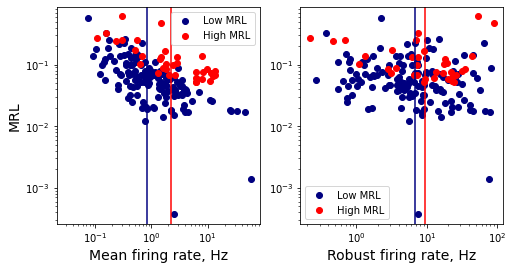

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.scatter(FR_mx[idxs_MRL_low][:, 0], FR_mx[idxs_MRL_low][:, 2], color='navy', label='Low MRL')
ax.scatter(FR_mx[idxs_MRL_high][:, 0], FR_mx[idxs_MRL_high][:, 2], color='red', label='High MRL')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Mean firing rate, Hz', fontsize=14)
ax.set_ylabel('MRL', fontsize=14)
ax.axvline(np.median(FR_mx[:, 0][idxs_MRL_low]), color='navy')
ax.axvline(np.median(FR_mx[:, 0][idxs_MRL_high]), color='red')
#ax.set_xlim(0, 20)
ax.legend()

ax = axes[1]
ax.scatter(FR_mx[idxs_MRL_low][:, 1], FR_mx[idxs_MRL_low][:, 2], color='navy', label='Low MRL')
ax.scatter(FR_mx[idxs_MRL_high][:, 1], FR_mx[idxs_MRL_high][:, 2], color='red', label='High MRL')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Robust firing rate, Hz', fontsize=14)
ax.axvline(np.median(FR_mx[:, 1][idxs_MRL_low]), color='navy')
ax.axvline(np.median(FR_mx[:, 1][idxs_MRL_high]), color='red')
#ax.set_xlim(0, 20)
ax.legend()

# SIC medians of high / low MRL
stat, p_value = scipystats.mannwhitneyu(FR_mx[:, 0][idxs_MRL_low], FR_mx[:, 0][idxs_MRL_high], alternative='two-sided')
print(f"MFR difference between high / low MRL, p_value: {p_value:.5f}")

# spatially selective units tend to be more stimulus phase-locked
corr, pv = scipystats.spearmanr(FR_mx[:, 0], FR_mx[:, 2])
#corr, pv = scipystats.pearsonr(FR_mx[:, 0], FR_mx[:, 2])
print(f"MFR / MRL correlation: {corr:.2f}, p={pv:.5f}")

## Speed correlations

In [131]:
speed_MRL_mx = np.zeros([len(unit_ids), 3])  # speed corr coeff, pv, MRL

# remove outliers
speed = np.array(tl[:, 3])
speed[np.where(speed > speed.mean() + 5*speed.std())[0]] = speed.mean() + 5*speed.std()

for i, unit_id in enumerate(unit_ids):
    i_rate = inst_rates[unit_id]
    
    corr, pv = scipystats.pearsonr(i_rate, speed)
    speed_MRL_mx[i] = np.array([corr, pv, MRL_mx[i][0]])

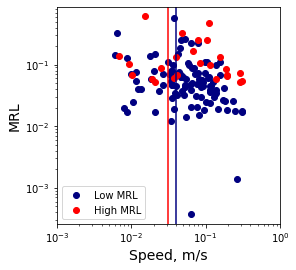

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(speed_MRL_mx[idxs_MRL_low][:, 0], speed_MRL_mx[idxs_MRL_low][:, 2], color='navy', label='Low MRL')
ax.scatter(speed_MRL_mx[idxs_MRL_high][:, 0], speed_MRL_mx[idxs_MRL_high][:, 2], color='red', label='High MRL')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Speed, m/s', fontsize=14)
ax.set_ylabel('MRL', fontsize=14)
ax.axvline(np.median(speed_MRL_mx[:, 0][idxs_MRL_low]), color='navy')
ax.axvline(np.median(speed_MRL_mx[:, 0][idxs_MRL_high]), color='red')
ax.set_xlim(0.001, 1)
ax.legend()